# Visualize CU or TU partition map

In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### Given a string of depths which is composed of the depth of each 4x4 block in quadtree, firstly, change the form into a 2-dimensional list with the same size as testsequence frame, secondly, take advantage of the list to generate partition map.

In [2]:
#aspect_ratio of each class 
aspect_ratio={
    'ClassB_shape':(1920, 1080), 'ClassB_shape_pad':(1920, 1088),
    'ClassC_shape':(832, 480), 'ClassC_shape_pad':(832, 512),
    'ClassD_shape':(416, 240), 'ClassD_shape_pad':(448, 256),
    'ClassE_shape':(1280, 720), 'ClassE_shape_pad':(1280, 768)
}

w = None
h = None

w_pad = None
h_pad = None

widthInCTU = None
heightInCTU = None

#get CU and TU depth map list. we can leverage it to generate CU and TU partiition map latter.
def get_depth_map_list(depth_stream):
    #CTU row
    row = 0
    #every line in CTU
    line = 0
    count = 0

    curCTU = 0

    depth_map_list = []
    for i in range(heightInCTU*64):
        depth_map_list.append([])

    for d in depth_stream:
        for l in range(4):
            for _ in range(4):
                depth_map_list[row*64+line*4+l].append(d)
        count += 16
        #a CTU is done. update some values
        if count == 4096:
            line = 0
            count = 0
            curCTU += 1
            if curCTU % widthInCTU == 0:
                row += 1
            continue
        #a line in a CTU is done. go to next line
        if count%256 == 0:
            line += 1
    return depth_map_list

# '1' : pixels of edges, '0' : otherwise
def get_partition_map(depth_map_list):
    parition_map_list =[]
    for i in range(heightInCTU*64):
        parition_map_list.append([])

    def isVerBoundary(i, j, CUorTU_size, CUorTU_depth):
        left = (j+1) % CUorTU_size == 0 and (j+1) < widthInCTU*64 and (int(depth_map_list[i][j]) >= CUorTU_depth and int(depth_map_list[i][j+1]) >= CUorTU_depth)
        right = j % CUorTU_size == 0 and j-1 >= 0 and (int(depth_map_list[i][j]) >= CUorTU_depth and int(depth_map_list[i][j-1]) >= CUorTU_depth)
        return left or right

    def isHorBoundary(i, j, CUorTU_size, CUorTU_depth):
        up = (i+1) % CUorTU_size == 0 and (i+1) < heightInCTU*64 and (int(depth_map_list[i][j]) >= CUorTU_depth and int(depth_map_list[i+1][j]) >= CUorTU_depth)
        down = i % CUorTU_size == 0 and i-1 >= 0 and (int(depth_map_list[i][j]) >= CUorTU_depth and int(depth_map_list[i-1][j]) >= CUorTU_depth)
        return up or down

    for i in range(heightInCTU*64):
        for j in range(widthInCTU*64):
            if isVerBoundary(i, j, 64, 0) or isVerBoundary(i, j, 32, 1) or isVerBoundary(i, j, 16, 2) or isVerBoundary(i, j, 8, 3) or isVerBoundary(i, j, 4, 4):
                parition_map_list[i].append(1) #pixels of edges
            elif isHorBoundary(i, j, 64, 0) or isHorBoundary(i, j, 32, 1) or isHorBoundary(i, j, 16, 2) or isHorBoundary(i, j, 8, 3) or isHorBoundary(i, j, 4, 4):
                parition_map_list[i].append(1) #pixels of edges
            else:
                parition_map_list[i].append(0)

    parition_map = np.array(parition_map_list)
    return parition_map

def get_partition_map_from_frame_seq(file_name):        

    frame_file = open(file_name, 'r')
    string = frame_file.read()
    string = string.split()
    depth_map_list = get_depth_map_list(string)
    partition_map = get_partition_map(depth_map_list)

    img = Image.fromarray(partition_map.astype('uint8')*255).convert('YCbCr') #*255 for visualization => edge:white otherwise:black

    return img

### Take 'ClassD - RaceHorse' as an example

In [3]:
w = aspect_ratio['ClassD_shape'][0]
h = aspect_ratio['ClassD_shape'][1]
w_pad = aspect_ratio['ClassD_shape_pad'][0]
h_pad = aspect_ratio['ClassD_shape_pad'][1]
widthInCTU = w_pad//64
heightInCTU = h_pad//64

#get CU partition map
file_name_CU = "test sequence data/frame/CU_RaceHorses_QP37/0_CU_frame.txt"
img_CU_seq = get_partition_map_from_frame_seq(file_name_CU)

#get TU partition map
file_name_TU = "test sequence data/frame/TU_RaceHorses_QP37/0_TU_frame.txt"
img_TU_seq = get_partition_map_from_frame_seq(file_name_TU)

==================== CU partition map ====================


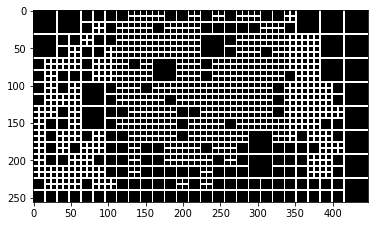


====================TU partition map ====================


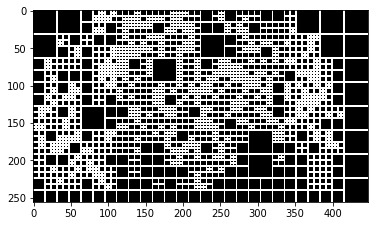

In [4]:
print("==================== CU partition map ====================")
plt.imshow(img_CU_seq)
plt.show()

print()
print("====================TU partition map ====================")
plt.imshow(img_TU_seq)
plt.show()

### process test sequence frame and visualize it

In [5]:
file_name_dst = "test sequence data/frame/distorted_image_RaceHorses_QP37/0_dst_frame.txt"
def get_image_from_frame_seq(file_name):
    
    frame_file = open(file_name, 'r')
    string = frame_file.read()

    string = string.split()
    
    img_string = []
    
    frame_arr = None
    
    for i in range(h):
        frame = []
        for j in range(w):
            frame.append(string[i*w + j])
        arr = np.array(frame, dtype=np.int32)
        if frame_arr is None:
            frame_arr = arr
        else:
            frame_arr = np.vstack((frame_arr, arr))

    img = Image.fromarray(frame_arr.astype('uint8')).convert('YCbCr')
    
    return img

In [6]:
img_dst_seq = get_image_from_frame_seq(file_name_dst)
img_dst_seq_pad = Image.new("YCbCr", (w_pad, h_pad)) 
img_dst_seq_pad.paste(img_dst_seq, (0, 0)) #mimic HM padding to make the width and the height be divisible by 64(CTU size:64x64)

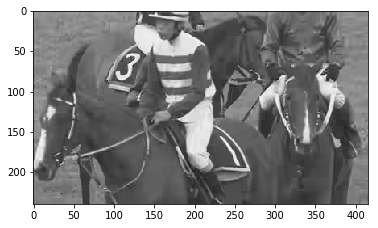

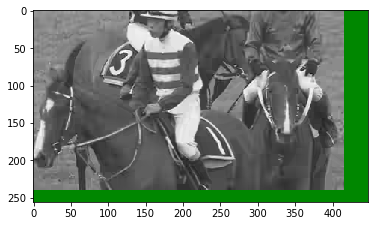

In [7]:
plt.imshow(img_dst_seq)
plt.show()
plt.imshow(img_dst_seq_pad)
plt.show()

### plot the partition on the original frame

In [8]:
arr_dst_seq_pad_CU =np.array(img_dst_seq_pad, dtype = np.uint8)[:,:,0]
arr_dst_seq_pad_TU =np.array(img_dst_seq_pad, dtype = np.uint8)[:,:,0]
arr_CU_seq=np.array(img_CU_seq, dtype = np.uint8)[:,:,0]
arr_TU_seq=np.array(img_TU_seq, dtype = np.uint8)[:,:,0]

In [9]:
for row in range(arr_dst_seq_pad_CU.shape[0]):
    for col in range(arr_dst_seq_pad_CU.shape[1]):
        if arr_CU_seq[row][col] == 255:
            arr_dst_seq_pad_CU[row][col] = 255
            
            
for row in range(arr_dst_seq_pad_TU.shape[0]):
    for col in range(arr_dst_seq_pad_TU.shape[1]):
        if arr_TU_seq[row][col] == 255:
            arr_dst_seq_pad_TU[row][col] = 255

==================== CU partition ====================


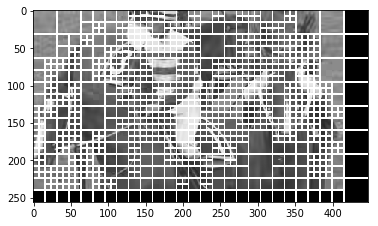

==================== TU partition ====================


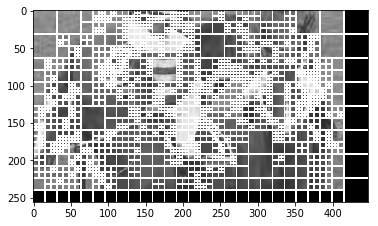

In [10]:
print("==================== CU partition ====================")
img_vis_CU = Image.fromarray(arr_dst_seq_pad_CU.astype('uint8')).convert('YCbCr')
plt.imshow(img_vis_CU)
plt.show()

print("==================== TU partition ====================")
img_vis_TU = Image.fromarray(arr_dst_seq_pad_TU.astype('uint8')).convert('YCbCr')
plt.imshow(img_vis_TU)
plt.show()